In [15]:
import xarray as xr
import numpy as np
from collections import namedtuple
import regionmask
import datetime
import pandas as pd
from extremeweatherbench import calc
from scipy.ndimage import gaussian_filter
import requests
from typing import Union, Literal, Optional

# Permutation Notes

As I'm writing out the MWE's, here's some notes on what I think might need to be accounted for:

Severe convection tbd
1. Models that run every 3, 6, 12, 24 hours and how that translates to the max/min metrics (all valid times in a 12 hour frequency/6 hour resolution have 21 lead times, for example, compared to 6/6 runs with 41)
2. When to aggregate over lat/lons for area-averaged metrics
3. When to remove ocean gridpoints to avoid improper comparisons (e.g. forecasts spatially aggregated with ocean vs ERA5 aggregated without)
4. (severe) Need to map ERA5 to the forecast to match pressure levels, else there will be a significant penalty loading in unneeded levels, and the risk of calculating the outputs with the 37 pressure levels prior to subset - apples to oranges comparison
5. (freeze, severe, tc, ar) Each variable adds ~30 seconds of wall time to load into memory. Need to eventually tackle how to manage this and determine if there's a more performant way to run (e.g. loading all data for all event cases in at once vs one at a time)
6. (severe) If we're concerned about CBSS producing "tails" outside of the severe zone, we might be able to perform a normalization against ERA5 data of some kind to augment on top of using a threshold percentile for PPH. For example, we can calculate both the ERA5 and AIWP CBSS and construct a ratio or normalized value to then compare to PPH... we can also consider an intersection of derived variables, such as the intersection of CBSS and (gaussian smoothed?) 700 hPa vertical velocity
7. (severe) storm reports act like point observations, and are stacked similarly to GHCN data. PPH is similarly treated like gridded data. Both hint at a pattern that can be constructed - are these observations point-based or gridded? Can we further reduce gridded data to stacked identically to point obs?

In [3]:
def dewpoint_from_specific_humidity(specific_humidity: xr.DataArray, pressure: xr.DataArray) -> xr.DataArray:
    """Calculate dewpoint from specific humidity, temperature, and pressure.
    
    Args:
        specific_humidity: The specific humidity DataArray.
        pressure: The pressure DataArray.

    Returns:
        The dewpoint DataArray.
    """
    mixing_ratio = specific_humidity / (1 - specific_humidity)
    e = pressure * mixing_ratio / (calc.epsilon + mixing_ratio)

    return calc.dewpoint_from_vapor_pressure(e)


def wind_speed_direction_to_uv(wind_speed: xr.DataArray, wind_direction: xr.DataArray) -> tuple[xr.DataArray, xr.DataArray]:
    """Convert wind speed and direction to u and v components.
    
    Args:
        wind_speed: The wind speed DataArray.
        wind_direction: The wind direction DataArray.
    """ 
    u = -wind_speed * np.sin(np.deg2rad(wind_direction))
    v = -wind_speed * np.cos(np.deg2rad(wind_direction))

    return u, v

def convert_longitude_to_360(longitude: float) -> float:
    """Convert a longitude from the range [-180, 180) to [0, 360)."""
    return np.mod(longitude, 360)

def lead_time_init_time_to_valid_time(forecast):
    """Convert init_time and lead_time to valid_time.
    
    Args:
        forecast: The forecast dataset.

    Returns:
        The forecast dataset with valid_time dimension.
    """
    if 'lead_time' not in forecast.dims or 'init_time' not in forecast.dims:
        raise ValueError("lead_time and init_time must be dimensions of the forecast dataset")
    
    lead_time_grid, init_time_grid = np.meshgrid(forecast.lead_time, forecast.init_time)
    valid_times = (
    init_time_grid.flatten()
    + pd.to_timedelta(lead_time_grid.flatten(), unit="h").to_numpy()
    )
    return valid_times

# Subset timesteps for forecast
def derive_indices_from_init_time_and_lead_time(
    dataset: xr.Dataset,
    start_date: datetime.datetime,
    end_date: datetime.datetime,
) -> np.ndarray:
    """Derive the indices of valid times in a dataset when the dataset has init_time and lead_time coordinates.

    Args:
        dataset: The dataset to derive the indices from.
        start_date: The start date to derive the indices from.
        end_date: The end date to derive the indices from.

    Returns:
        The indices of valid times in the dataset.

    Example:
        >>> import xarray as xr
        >>> import datetime
        >>> import pandas as pd
        >>> from extremeweatherbench.utils import (
        ...     derive_indices_from_init_time_and_lead_time,
        ... )
        >>> ds = xr.Dataset(
        ...     coords={
        ...         "init_time": pd.date_range("2020-01-01", "2020-01-03"),
        ...         "lead_time": [0, 24, 48],  # hours
        ...     }
        ... )
        >>> start = datetime.datetime(2020, 1, 1)
        >>> end = datetime.datetime(2020, 1, 4)
        >>> indices = derive_indices_from_init_time_and_lead_time(ds, start, end)
        >>> print(indices)
        array([0, 0, 1, 1, 2])
    """
    valid_times = lead_time_init_time_to_valid_time(dataset)
    valid_times_reshaped = valid_times.reshape(
        (
            dataset.init_time.shape[0],
            dataset.lead_time.shape[0],
        )
    )
    valid_time_mask = (valid_times_reshaped > pd.to_datetime(start_date)) & (
        valid_times_reshaped < pd.to_datetime(end_date)
    )
    valid_time_indices = np.asarray(valid_time_mask).nonzero()

    # The first index will subset init_time based on the first valid_time_reshaped line above
    # we don't need to subset lead_time but it might be useful in the future
    init_time_subset_indices = valid_time_indices[0]

    return init_time_subset_indices

def remove_ocean_gridpoints(dataset: xr.Dataset,drop: bool = True) -> xr.Dataset:
    """Subset a dataset to only include land gridpoints based on a land-sea mask.

    Args:
        dataset: The input xarray dataset.

    Returns:
        The dataset masked to only land gridpoints.
    """
    land = regionmask.defined_regions.natural_earth_v5_0_0.land_110
    land_sea_mask = land.mask(dataset.longitude, dataset.latitude)
    land_mask = land_sea_mask == 0
    # Subset the dataset to only include land gridpoints
    return dataset.where(land_mask, drop=drop)


In [4]:
#event metadata
start_date = pd.Timestamp('2020-04-22 12:00:00')
end_date = pd.Timestamp('2020-04-23 12:00:00')
Location = namedtuple('Location', ['latitude', 'longitude'])

#using predefined boxes instead of bounding box degrees for severe
# location = Location(latitude=31.21, longitude=-92.46)
# bounding_box_degrees = 5
variables = ['air_temperature','eastward_wind','northward_wind','specific_humidity']

In [5]:
# Bounding box coordinates for eastern CONUS (east of Mississippi River)
# Format: [min_lat, max_lat, min_lon, max_lon]
eastern_conus_bbox = [24.0, 49.0, -89.0, -67.0]  # Roughly follows Mississippi River to Atlantic coast
# Bounding box coordinates for central CONUS (Mississippi River to Rocky Mountains)
central_conus_bbox = [24.0, 49.0, -109.0, -89.0]  # Mississippi River to Rockies

# Bounding box coordinates for western CONUS (west of Rocky Mountains)
western_conus_bbox = [24.0, 49.0, -125.0, -109.0]  # Pacific coast to Rockies


In [7]:
#: Storage location for ERA5.
ERA5_URI = "gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3"
era5 = xr.open_zarr(
    ERA5_URI,
    chunks=None,
    storage_options=dict(token="anon"),
)
#Convert ERA5 to event dates
era5_case = era5.sel(
    time=slice(
        start_date,
        end_date,
    )
)

#Take freeze variables; named differently between era5, ghcn observations and forecasts
era5_case = era5_case[['temperature','u_component_of_wind','v_component_of_wind','specific_humidity']]

era5_case = era5_case.sel(
    latitude=slice(central_conus_bbox[1], central_conus_bbox[0]),  # max_lat to min_lat
    longitude=slice(convert_longitude_to_360(central_conus_bbox[2]), convert_longitude_to_360(central_conus_bbox[3]))  # min_lon to max_lon
).rename({'time':'valid_time'})

prepared_era5 = remove_ocean_gridpoints(era5_case,drop=False)
prepared_era5['pressure'] = xr.broadcast(prepared_era5['level'], prepared_era5['temperature'])[0]
prepared_era5['dewpoint'] = dewpoint_from_specific_humidity(prepared_era5['specific_humidity'], prepared_era5['pressure'])
prepared_era5 = prepared_era5.transpose('valid_time','latitude','longitude','level')


In [8]:
prepared_era5

<xarray.Dataset> Size: 242MB
Dimensions:              (valid_time: 25, level: 37, latitude: 101,
                          longitude: 81)
Coordinates:
  * latitude             (latitude) float32 404B 49.0 48.75 48.5 ... 24.25 24.0
  * level                (level) int64 296B 1 2 3 5 7 ... 900 925 950 975 1000
  * longitude            (longitude) float32 324B 251.0 251.2 ... 270.8 271.0
  * valid_time           (valid_time) datetime64[ns] 200B 2020-04-22T12:00:00...
Data variables:
    temperature          (valid_time, latitude, longitude, level) float32 30MB ...
    u_component_of_wind  (valid_time, latitude, longitude, level) float32 30MB ...
    v_component_of_wind  (valid_time, latitude, longitude, level) float32 30MB ...
    specific_humidity    (valid_time, latitude, longitude, level) float32 30MB ...
    pressure             (valid_time, latitude, longitude, level) int64 61MB ...
    dewpoint             (valid_time, latitude, longitude, level) float64 61MB ...
Attributes:
    last_updated:           2025-06-07 19:18:54.793707+00:00
    valid_time_start:       1940-01-01
    valid_time_stop:        2025-02-28
    valid_time_stop_era5t:  2025-06-01

In [9]:
# Forecast
forecast_dir = "gs://weatherbench2/datasets/hres/2016-2022-0012-1440x721.zarr"
forecast_ds = xr.open_zarr(forecast_dir, chunks="auto")
forecast_ds = forecast_ds.rename({'prediction_timedelta':'lead_time','time':'init_time'})

#HRES reverse of ERA5 for latitude slicing
forecast_case = forecast_ds[['temperature','u_component_of_wind','v_component_of_wind','specific_humidity']]
forecast_case = forecast_case.sel(
    latitude=slice(central_conus_bbox[0],central_conus_bbox[1]),  # max_lat to min_lat
    longitude=slice(convert_longitude_to_360(central_conus_bbox[2]), convert_longitude_to_360(central_conus_bbox[3]))  # min_lon to max_lon
)

valid_times = lead_time_init_time_to_valid_time(forecast_case)
# Create new dataset with valid_time dimension
subset_forecast_flat = forecast_case.stack(time_stack=['init_time', 'lead_time'])
subset_forecast_flat=subset_forecast_flat.assign_coords(valid_time=(('time_stack'), valid_times)).swap_dims({'time_stack':'valid_time'})

# Subset forecast valid times to the tolerance range (for heatwaves, 48 hours)
# The tolerance range is used to capture biases in case timing (e.g. the forecast heat wave initialization was 1 day early)
forecast_time_mask = (subset_forecast_flat.valid_time >= start_date-pd.Timedelta(days=2)) & (subset_forecast_flat.valid_time <= end_date+pd.Timedelta(days=2))

## Added compute here because fastest by at least 10 seconds
subset_forecast_flat = subset_forecast_flat.where(forecast_time_mask,drop=True).compute()

# subset_forecast_flat = remove_ocean_gridpoints(subset_forecast_flat,drop=False)
prepared_forecast = subset_forecast_flat.set_index(time_stack=['lead_time','valid_time']).unstack('time_stack')
prepared_forecast['pressure'] = xr.broadcast(prepared_forecast['level'], prepared_forecast['temperature'])[0]
prepared_forecast['dewpoint'] = dewpoint_from_specific_humidity(prepared_forecast['specific_humidity'], prepared_forecast['pressure'])
prepared_forecast = prepared_forecast.transpose('valid_time','lead_time','latitude','longitude','level')

/home/taylor/code/ExtremeWeatherBench/.venv/lib/python3.12/site-packages/xarray/core/computation.py:818: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


In [192]:
#storm reports and PPH data
def pull_lsr_data(date: pd.Timestamp) -> pd.DataFrame:
    """Pull the latest LSR data for a given date. A "date" for LSRs is considered the
    date starting at 12 UTC to the next day at 11:59 UTC.
    
    Args:
        date: A pandas Timestamp object.
    Returns:
        df: A pandas DataFrame containing the LSR data with columns lat, lon, report_type, time, and scale.
    """
    # Try the filtered URL first, if it fails, try without _filtered
    url = f"https://www.spc.noaa.gov/climo/reports/{date.strftime('%y%m%d')}_rpts_filtered.csv"
    # Check if the URL exists by attempting to open it
    response = requests.head(url)
    if date < pd.Timestamp('2004-02-29'):
        raise ValueError("LSR data before 2004-02-29 is not available in CSV format")
    if response.status_code == 404:
        # If the filtered URL doesn't exist, use the non-filtered version
        url = f"https://www.spc.noaa.gov/climo/reports/{date.strftime('%y%m%d')}_rpts.csv"
    # Read the CSV file with all columns to identify report types
    try:
        df = pd.read_csv(url, delimiter=',', engine='python', names=['Time','Scale','Location','County','State','Lat','Lon','Comments'])
    except Exception as e:
        print(f'Error pulling LSR data for {date}: {e}')
        return pd.DataFrame()
    if len(df) == 3:
        return pd.DataFrame()
    # Initialize report_type column
    df['report_type'] = None
    
    # Find rows with headers and mark subsequent rows with appropriate report type
    for i, row in df.iterrows():
        if 'F_Scale' in row.values:
            df.loc[i+1:, 'report_type'] = 'tor'
        elif 'Speed' in row.values:
            df.loc[i+1:, 'report_type'] = 'wind'
        elif 'Size' in row.values:
            df.loc[i+1:, 'report_type'] = 'hail'
    
    # Keep only necessary columns
    df = df[['Lat', 'Lon', 'report_type','Time', "Scale"]]
    # Remove rows that have 'Lat' in the 'Lat' column (these are header rows)
    df = df[df['Lat'] != 'Lat']
    time = pd.to_datetime(df['Time'], format='%H%M').dt.time
    df['Time'] = pd.to_datetime(date.strftime('%Y-%m-%d') + ' ' + time.astype(str))
    df = df.rename(columns={'Lat': 'lat', 'Lon': 'lon','Time':'time'})
    return df

def pull_lsr_data(date: pd.Timestamp) -> pd.DataFrame:
    """Pull the latest LSR data for a given date. A "date" for LSRs is considered the
    date starting at 12 UTC to the next day at 11:59 UTC.
    
    Args:
        date: A pandas Timestamp object.
    Returns:
        df: A pandas DataFrame containing the LSR data.
    """
    # Try the filtered URL first, if it fails, try without _filtered
    url = f"https://www.spc.noaa.gov/climo/reports/{date.strftime('%y%m%d')}_rpts_filtered.csv"
    # Check if the URL exists by attempting to open it
    response = requests.head(url)
    if date < pd.Timestamp('2004-02-29'):
        raise ValueError("LSR data before 2004-02-29 is not available in CSV format")
    if response.status_code == 404:
        # If the filtered URL doesn't exist, use the non-filtered version
        url = f"https://www.spc.noaa.gov/climo/reports/{date.strftime('%y%m%d')}_rpts.csv"
    # Read the CSV file with all columns to identify report types
    df = pd.read_csv(url, delimiter=',', engine='python', names=['Time','Scale','Location','County','State','Lat','Lon','Comments'])
    
    # Initialize report_type column
    df['report_type'] = None
    
    # Find rows with headers and mark subsequent rows with appropriate report type
    for i, row in df.iterrows():
        if 'F_Scale' in row.values:
            df.loc[i+1:, 'report_type'] = 'tor'
        elif 'Speed' in row.values:
            df.loc[i+1:, 'report_type'] = 'wind'
        elif 'Size' in row.values:
            df.loc[i+1:, 'report_type'] = 'hail'
    
    # Keep only necessary columns
    df = df[['Lat', 'Lon', 'report_type']]
    # Remove rows that have 'Lat' in the 'Lat' column (these are header rows)
    df = df[df['Lat'] != 'Lat']
    df = df.rename(columns={'Lat': 'lat', 'Lon': 'lon'})
    return df

def practically_perfect_hindcast(
    date: pd.Timestamp,
    resolution: float = 0.25,
    report_type: Union[Literal["all"], list[Literal["tor", "hail", "wind"]]] = "all",
    sigma: float = 1.5,
    return_reports: bool = False,
    output_resolution: Optional[float] = None
) -> Union[xr.DataArray, tuple[xr.DataArray, pd.DataFrame]]:
    """Compute the Practically Perfect Hindcast (PPH) using storm report data using latitude/longitude grid spacing
    instead of the NCEP 212 Eta Lambert Conformal projection; based on the method described in Hitchens et al 2013,
    https://doi.org/10.1175/WAF-D-12-00113.1

    Args:
        date: A pandas Timestamp object.
        resolution: The resolution of the grid to use. Default is 0.25 degrees.
        report_type: The type of report to use. Default is all. Currently only supports all.
        sigma: The sigma (standard deviation) of the gaussian filter to use. Default is 1.5.
        return_reports: Whether to return the reports used to compute the PPH. Default is False.
        output_resolution: The resolution of the output grid. Default is None (keep the same resolution as the input grid).
    Returns:
        pph: An xarray DataArray containing the PPH around the storm report data.
    """

    df = pull_lsr_data(date)
    if report_type == "all":
        pass
    else:
        df = df[df['report_type'].isin(report_type)]

    # Extract latitude and longitude from the dataframe
    lats = df["lat"].astype(float)
    lons = df["lon"].astype(float)

    # Create a grid covering the continental US (or adjust as needed)
    lat_min, lat_max = 24.0, 50.0  # Continental US approximate bounds
    lon_min, lon_max = -125.0, -66.0  # Continental US approximate bounds

    # Create the grid coordinates
    grid_lats = np.arange(lat_min, lat_max + resolution, resolution)
    grid_lons = np.arange(lon_min, lon_max + resolution, resolution)

    # Initialize an empty grid
    grid = np.zeros((len(grid_lats), len(grid_lons)))

    # Mark grid cells that contain reports
    for lat, lon in zip(lats, lons):
        # Find the nearest grid indices
        lat_idx = np.abs(grid_lats - lat).argmin()
        lon_idx = np.abs(grid_lons - lon).argmin()
        grid[lat_idx, lon_idx] = 1

    # Create the xarray DataArray
    pph = xr.DataArray(
        grid,
        dims=["latitude", "longitude"],
        coords={"latitude": grid_lats, "longitude": grid_lons},
        name="practically_perfect",
    )

    # Apply bilinear interpolation to smooth the field
    # First, create a gaussian kernel for smoothing
    smoothed_grid = gaussian_filter(grid, sigma=sigma)

    # Replace the data in the DataArray
    pph.data = smoothed_grid

    # Find the bounds of non-zero data
    nonzero_lats = np.where(pph.data.any(axis=1))[0]
    nonzero_lons = np.where(pph.data.any(axis=0))[0]
    
    # Get the min/max indices
    lat_start, lat_end = nonzero_lats[0], nonzero_lats[-1]
    lon_start, lon_end = nonzero_lons[0], nonzero_lons[-1]

    pph = pph.isel(
        latitude=slice(lat_start, lat_end + 1),
        longitude=slice(lon_start, lon_end + 1)
    )    
    pph['longitude'] = convert_longitude_to_360(pph['longitude'])
    pph = pph.interp(
        latitude=prepared_forecast.latitude,
        longitude=prepared_forecast.longitude,
        method='linear'
    )
    if return_reports:
        return (pph, df)
    return pph

prepared_pph, report_df = practically_perfect_hindcast(start_date, resolution=0.78, return_reports=True,output_resolution=0.25)
prepared_pph = prepared_pph.dropna(dim='latitude', how='all').dropna('longitude', how='all').to_dataset()
prepared_pph['valid_time'] = [start_date]



In [114]:
report_ds = (report_df
 .astype({'lat':float,'lon':float})
 .to_xarray()
)
report_ds = report_ds.assign_coords(latitude=report_ds.lat,longitude=report_ds.lon)
report_ds['longitude'] = convert_longitude_to_360(report_ds['longitude'])
report_ds = report_ds.swap_dims({'index':'location'}).set_index(location=('latitude','longitude'))
report_ds['valid_time'] = [start_date]
prepared_reports = report_ds.where(report_ds['report_type'].isin(['tor','hail']),drop=True)
prepared_reports

<xarray.Dataset> Size: 6kB
Dimensions:      (location: 103, valid_time: 1)
Coordinates:
    index        (location) int64 824B 1 2 3 4 5 6 7 ... 187 188 189 190 191 192
  * location     (location) object 824B MultiIndex
  * latitude     (location) float64 824B 34.67 34.32 34.05 ... 30.45 30.48 30.56
  * longitude    (location) float64 824B 262.7 262.9 263.2 ... 268.8 269.0 269.1
  * valid_time   (valid_time) datetime64[ns] 8B 2020-04-22T12:00:00
Data variables:
    lat          (location) float64 824B 34.67 34.32 34.05 ... 30.45 30.48 30.56
    lon          (location) float64 824B -97.31 -97.13 -96.82 ... -90.96 -90.93
    report_type  (location) object 824B 'tor' 'tor' 'tor' ... 'hail' 'hail'

# Derived Variable(s) (CBSS)

In [103]:
import importlib
import extremeweatherbench.calc as calc
importlib.reload(calc)


ModuleNotFoundError: spec not found for the module 'extremeweatherbench.calc'

In [131]:
# Create dummy data arrays with same dimensions as prepared_era5 and prepared_forecast
# but with values ranging from 0 to 60,000

import numpy as np

# Get dimensions from the forecast data
time_dim = len(prepared_forecast.valid_time)
lead_dim = len(prepared_forecast.lead_time)
lat_dim = len(prepared_forecast.latitude)
lon_dim = len(prepared_forecast.longitude)

# Create random data arrays scaled to 0-60000 range
era5_data = np.random.rand(time_dim, lat_dim, lon_dim) * 60000
forecast_data = np.random.rand(time_dim, lead_dim, lat_dim, lon_dim) * 60000

# Create xarray DataArrays with same coordinates as original data
prepared_era5['dummy_cbss'] = xr.DataArray(
    era5_data,
    coords={
        'valid_time': prepared_forecast.valid_time,
        'latitude': prepared_forecast.latitude,
        'longitude': prepared_forecast.longitude,
    },
    dims=['valid_time', 'latitude', 'longitude']
)

prepared_forecast['dummy_cbss'] = xr.DataArray(
    forecast_data,
    coords={
        'valid_time': prepared_forecast.valid_time,
        'lead_time': prepared_forecast.lead_time,
        'latitude': prepared_forecast.latitude, 
        'longitude': prepared_forecast.longitude,
    },
    dims=['valid_time', 'lead_time', 'latitude', 'longitude']
)


In [31]:
# era5_cbss = derived.craven_brooks_sig_svr(prepared_era5)
# forecast_cbss = derived.craven_brooks_sig_svr(prepared_forecast)

uh oh


/home/taylor/code/ExtremeWeatherBench/src/extremeweatherbench/calc.py:242: RuntimeWarning: invalid value encountered in scalar power
  pressure_new = pressure_0 * (td / temperature) ** (1.0 / kappa)


uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh oh
uh o

KeyboardInterrupt: 

# Onset Signal

# Contingency Table Metrics

Once the data is ready to be put through the metrics, scores has a one-stop-shop approach for all contingency table metrics that will be used for EWB. It is also perfectly suited for an MWE

In [194]:
import scores.categorical as cat
binary_forecast = (prepared_forecast['dummy_cbss'] >= 15000).astype(float)
binary_observation = (prepared_pph >= 0.30).astype(
    float
)

contingency_manager = cat.BinaryContingencyManager(
    binary_forecast, binary_observation
).transform(preserve_dims=["lead_time"])

## Critical Success Index (CSI/Regional IOU/Threat Score)

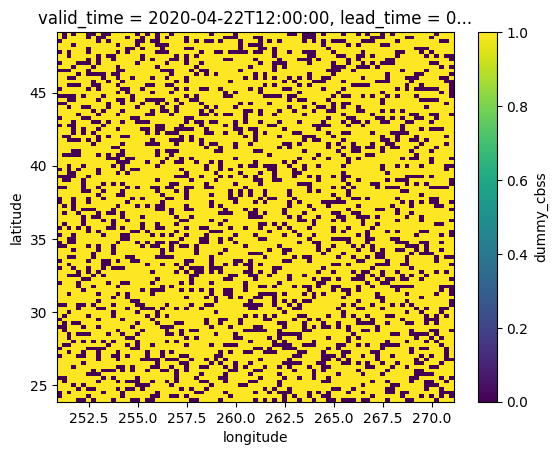

In [202]:
binary_forecast.sel(valid_time=start_date).isel(lead_time=0).plot()

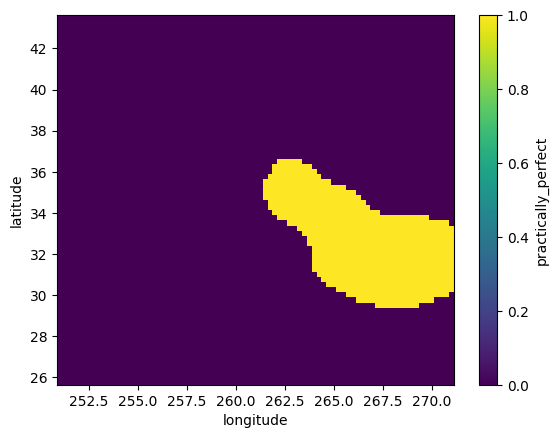

In [195]:
binary_observation['practically_perfect'].plot()

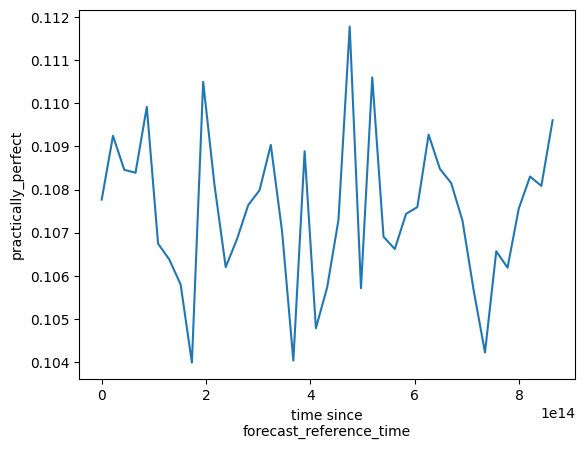

In [205]:
contingency_manager.critical_success_index()['practically_perfect'].plot()

## False Alarm Ratio (FAR)

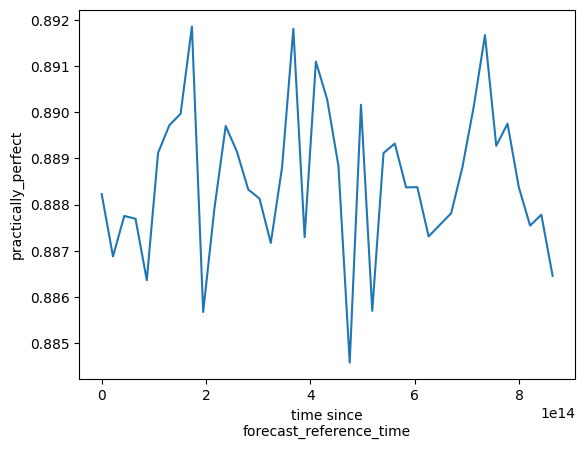

In [206]:
contingency_manager.false_alarm_ratio()['practically_perfect'].plot()

## Region Hits/Misses (Spatial Precision of PPH Region vs CBSS Region)

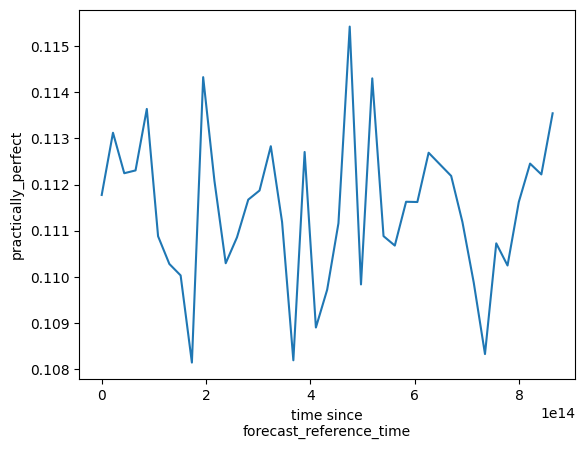

In [207]:
contingency_manager.precision()['practically_perfect'].plot()

## Hits/Misses of Reports (Spatial Precision of Reports)

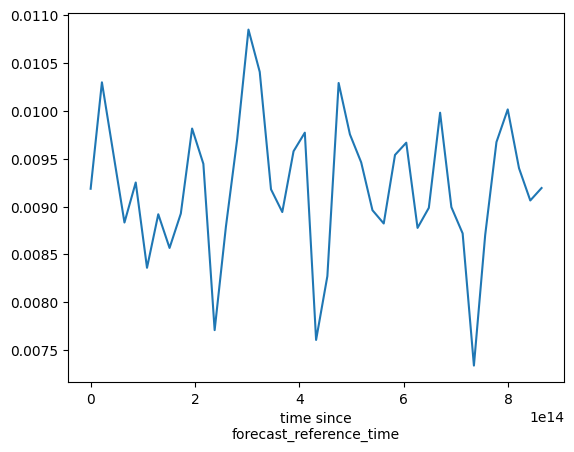

In [227]:
# First need to align forecast and observation points in prepared_reports.
# Unlike heatwaves or freeze, we aren't reducing the location or lat/lon dims.

# Stack the forecast data to have a location dimension
prepared_report_forecast = prepared_forecast.stack(location=['latitude','longitude'])

# Create binary forecast array by thresholding dummy_cbss
binary_report_forecast = (prepared_report_forecast['dummy_cbss'] >= 15000).astype(float)

# Create binary observation array by interpolating prepared_reports to forecast grid
binary_report_observation = xr.Dataset(
    coords={
        'location': prepared_report_forecast.location,
        'valid_time': prepared_reports.valid_time
    }
).assign(
    reports=(('valid_time', 'location'), 
             np.zeros((len(prepared_reports.valid_time), len(prepared_report_forecast.location))))
)

# For each valid time, mark grid cells containing reports as 1
for t in prepared_reports.valid_time:
    reports_at_t = prepared_reports.sel(valid_time=t)
    for i in range(len(reports_at_t.location)):
        lat = reports_at_t.latitude[i].item()
        lon = reports_at_t.longitude[i].item()
        # Find closest grid point
        dist = np.sqrt((prepared_report_forecast.latitude - lat)**2 + 
                      (prepared_report_forecast.longitude - lon)**2)
        closest_idx = dist.argmin()
        binary_report_observation.reports.loc[dict(valid_time=t, 
            location=prepared_report_forecast.location[closest_idx])] = 1

# Extract the reports array from the dataset
binary_report_observation = binary_report_observation.reports

# Create contingency manager for report forecast and observation
contingency_manager = cat.BinaryContingencyManager(
    binary_report_forecast, binary_report_observation
).transform(preserve_dims=["lead_time"])

# Plot precision (hits/misses) of reports
contingency_manager.precision().plot()
